In [10]:
import cv2
import numpy as np
import yaml

class ComputerVision:
    def __init__(self, calibration_file='calibration.yaml'):
        """
        Initializes the ComputerVision object, loads calibration data, and sets up camera capture.
        
        :param calibration_file: Path to the calibration file (default is 'calibration.yaml')
        """
        # Load calibration data
        with open(calibration_file, 'r') as f:
            calibration_data = yaml.safe_load(f)
        self.mtx = np.array(calibration_data['camera_matrix'])
        self.dist = np.array(calibration_data['dist_coeff'])
        
        # Define ARUCO dictionary to detect
        self.aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
        self.parameters = cv2.aruco.DetectorParameters()

        # Initialize the video capture (0 for default camera)
        self.cap = cv2.VideoCapture(0)
        
        # Get the optimal camera matrix
        ret, img = self.cap.read()
        if not ret:
            print("Error: Could not read from the camera.")
            exit()
        h, w = img.shape[:2]
        self.newcameramtx, self.roi = cv2.getOptimalNewCameraMatrix(self.mtx, self.dist, (w, h), 1, (w, h))

    def get_frame(self):
        ret, img = self.cap.read()
        if not ret:
            print("Error: Could not read from the camera.")
        return ret, img

    def process_frame(self):
        """
        Processes each frame to detect ArUco markers, calculate perspective transformation, and update the grid map.
        """
        ret, frame = self.cap.read()
        if not ret:
            print("Error: Could not read frame.")
            return None

        # Convert frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect ArUco markers
        corners, ids, rejected = cv2.aruco.detectMarkers(gray, self.aruco_dict, parameters=self.parameters)

        start_point = None
        end_point = None

        if ids is not None:
            # Detect start (6) and end (5) markers
            for i, marker_id in enumerate(ids.flatten()):
                marker_center = np.mean(corners[i][0], axis=0)  # Center of the marker

                if marker_id == 6:  # START
                    start_point = marker_center
                    cv2.circle(frame, tuple(start_point.astype(int)), 5, (0, 255, 0), -1)  # Draw green circle

                elif marker_id == 5:  # END
                    end_point = marker_center
                    cv2.circle(frame, tuple(end_point.astype(int)), 5, (0, 0, 255), -1)  # Draw red circle

            # Check if all four required corner markers are detected
            required_ids = {1, 2, 3, 4}
            marker_positions = {marker_id: corners[i][0] for i, marker_id in enumerate(ids.flatten())}
            if required_ids.issubset(marker_positions.keys()):
                rect_corners = np.array([
                    marker_positions[1][0],  # Top-left corner
                    marker_positions[2][1],  # Top-right corner
                    marker_positions[3][2],  # Bottom-right corner
                    marker_positions[4][3],  # Bottom-left corner
                ], dtype=np.float32)

                # Ensure rect_corners has the correct shape
                if rect_corners.shape == (4, 2):
                    # Define destination points for the flattened rectangle (6:8 aspect ratio)
                    width, height = 600, 800  # Desired output size with 6:8 aspect ratio
                    dst_corners = np.array([
                        [0, 0],
                        [width - 1, 0],
                        [width - 1, height - 1],
                        [0, height - 1]
                    ], dtype=np.float32)

                    # Compute the perspective transform matrix
                    matrix = cv2.getPerspectiveTransform(rect_corners, dst_corners)

                    # Apply perspective warp to get the top-down view
                    warped_image = cv2.warpPerspective(frame, matrix, (width, height))

                    # Convert warped image to grayscale and threshold it to create a binary map
                    gray_warped = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
                    _, binary_map = cv2.threshold(gray_warped, 100, 255, cv2.THRESH_BINARY_INV)

                    # Mask ArUco markers 5 and 6
                    for i, marker_id in enumerate(ids.flatten()):
                        if marker_id in {5, 6}:  # Mask START (6) and END (5)
                            marker_center = np.mean(corners[i][0], axis=0)  # Center of the marker
                            warped_center = cv2.perspectiveTransform(
                                np.array([[marker_center]], dtype=np.float32), matrix)[0][0]
                            warped_center_int = tuple(np.clip(warped_center.astype(int),
                                                              0, [binary_map.shape[1] - 1, binary_map.shape[0] - 1]))
                            cv2.circle(binary_map, warped_center_int, 100, 0, -1)  # Mask as white

                    # Create a grid map for pathfinding
                    grid_map = np.zeros_like(binary_map, dtype=int)

                    # Set obstacle regions (binary_map == 255)
                    grid_map[binary_map == 255] = 1

                    # Set start and end points in the grid map
                    if start_point is not None:
                        start_warped = cv2.perspectiveTransform(np.array([[start_point]], dtype=np.float32), matrix)[0][0]
                        start_coords = tuple(start_warped.astype(int))
                        grid_map[start_coords[1], start_coords[0]] = 3  # Start

                    if end_point is not None:
                        end_warped = cv2.perspectiveTransform(np.array([[end_point]], dtype=np.float32), matrix)[0][0]
                        end_coords = tuple(end_warped.astype(int))
                        grid_map[end_coords[1], end_coords[0]] = 2  # End

                    return grid_map

        return None

    def get_map(self):
        """
        Captures the grid map from camera and returns it.
        """
        grid_map = None
        while True:
            grid_map = self.process_frame()
            if grid_map is not None:
                print("Grid map generated.")
                break

            # Exit on 'q'
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break

        self.cap.release()
        cv2.destroyAllWindows()
        return grid_map


# Usage
cv = ComputerVision()
map = cv.get_map()

#print(map)


Grid map generated.


In [9]:

np.savetxt('map.txt', map, fmt='%d', delimiter=' ', comments='')

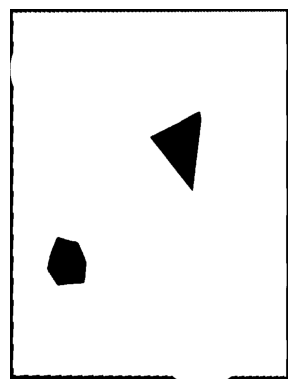

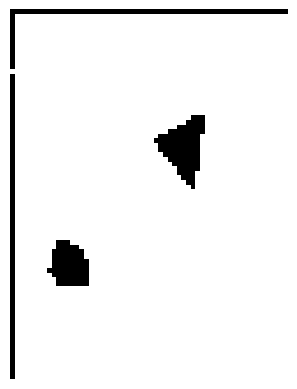

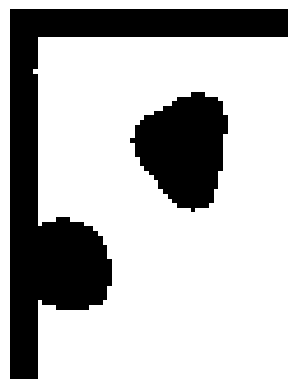

1435 operations to find the optimal path


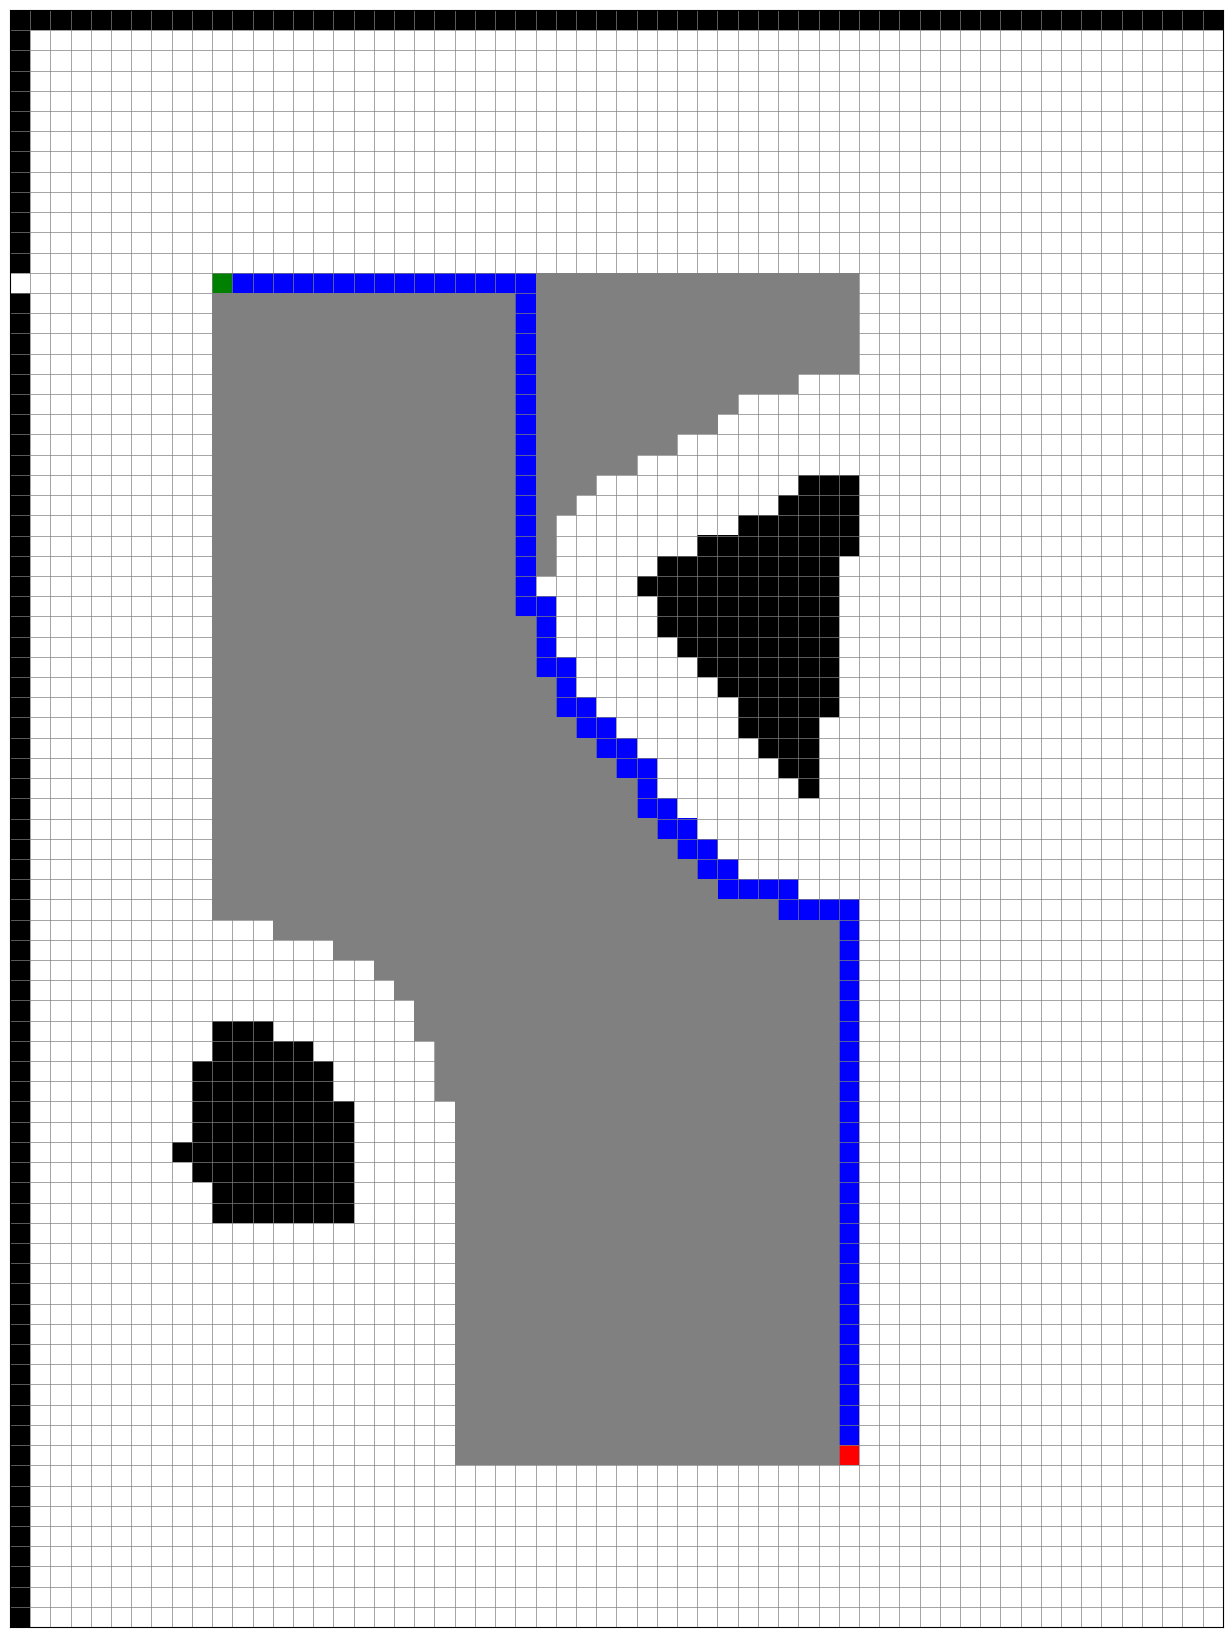

[(13, 10), (13, 11), (13, 12), (13, 13), (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (13, 20), (13, 21), (13, 22), (13, 23), (13, 24), (13, 25), (14, 25), (15, 25), (16, 25), (17, 25), (18, 25), (19, 25), (20, 25), (21, 25), (22, 25), (23, 25), (24, 25), (25, 25), (26, 25), (27, 25), (28, 25), (29, 25), (29, 26), (30, 26), (31, 26), (32, 26), (32, 27), (33, 27), (34, 27), (34, 28), (35, 28), (35, 29), (36, 29), (36, 30), (37, 30), (37, 31), (38, 31), (39, 31), (39, 32), (40, 32), (40, 33), (41, 33), (41, 34), (42, 34), (42, 35), (43, 35), (43, 36), (43, 37), (43, 38), (44, 38), (44, 39), (44, 40), (44, 41), (45, 41), (46, 41), (47, 41), (48, 41), (49, 41), (50, 41), (51, 41), (52, 41), (53, 41), (54, 41), (55, 41), (56, 41), (57, 41), (58, 41), (59, 41), (60, 41), (61, 41), (62, 41), (63, 41), (64, 41), (65, 41), (66, 41), (67, 41), (68, 41), (69, 41), (70, 41), (71, 41)]


In [11]:
import cv2
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop 

class AStarNavigation:
    def __init__(self, file_path, safety):
        self.file_path = file_path
        self.safety = safety
        self.image = None
        self.start = None
        self.goal = None
        self.map_grid = None
        self.path = None

    def visualization_map(self):
        # Load the text file and convert it to a self.image
        self.image = np.loadtxt(self.file_path)

        # Find the coordinates of the first occurrence of the digit 2, 3
        self.start = tuple(np.argwhere(self.image == 2)[0])
        self.goal = tuple(np.argwhere(self.image == 3)[0])

        # Replace all occurrences of the digit 2 and 3 with 0 for the map
        self.image[self.start] = 0
        self.image[self.goal] = 0

        # conversion for display
        self.image = np.where(self.image == 0, 255, self.image)
        self.image = np.where(self.image == 1, 0, self.image)

        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.show()
        
        # Resize the map to 100 pixels wide while maintaining the aspect ratio
        height, width = self.image.shape
        new_width = 60 #todo choose
        new_height = int((new_width / width) * height)
        self.image = cv2.resize(self.image, (new_width, new_height), interpolation=cv2.INTER_NEAREST) #todo explain
        
        # Update the start and goal positions after resizing
        start_y, start_x = self.start
        goal_y, goal_x = self.goal
        self.start = (int(start_y * new_height / height), int(start_x * new_width / width))
        self.goal = (int(goal_y * new_height / height), int(goal_x * new_width / width))
        
        
        # Display the self.image
        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.show()
    
        # conversion for self.path planning
        self.image = np.where(self.image == 0, -1., self.image)
        self.image = np.where(self.image == 255, 0., self.image)

    def safety_distance(self):
        # Find the coordinates of all black pixels (value -1)
        black_pixels = np.argwhere(self.image == -1)
        self.image_thick = np.full_like(self.image, 255)
        
        # Iterate through each black pixel and draw a gray border around it
        for pixel in black_pixels:
            y, x = pixel
            cv2.circle(self.image_thick, (x, y), self.safety, 0, -1)
        
        plt.imshow(self.image_thick, cmap='gray')
        plt.axis('off')
        plt.show()
    
        # conversion for path planning
        self.image_thick = np.where(self.image_thick == 0, -1., self.image_thick)
        self.image_thick = np.where(self.image_thick == 255, 0., self.image_thick)
        return self.image_thick

    @staticmethod
    def heuristic(a, b):
        # Implement the Manhattan distance heuristic
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def algo(self):
        # Initialize the open set as a priority queue and add the self.start node
        open_set = []
        heappush(open_set, (self.heuristic(self.start, self.goal), 0, self.start))  # (f_cost, g_cost, position)
    
        # Initialize the came_from dictionary
        came_from = {}
        # Initialize g_costs dictionary with default value of infinity and set g_costs[self.start] = 0
        g_costs = {self.start: 0}
        # Initialize the explored set
        explored = set()
        operation_count = 0
        self.path = []
    
        while open_set:
            # Pop the node with the lowest f_cost from the open set
            current_f_cost, current_g_cost, current_pos = heappop(open_set)
    
            # Add the current node to the explored set
            explored.add(current_pos)
    
            # For directly reconstruct self.path
            if current_pos == self.goal:
                break
    
            # Get the neighbors of the current node (up, down, left, right)
            neighbors = [
                (current_pos[0] - 1, current_pos[1]),  # Up
                (current_pos[0] + 1, current_pos[1]),  # Down
                (current_pos[0], current_pos[1] - 1),  # Left
                (current_pos[0], current_pos[1] + 1)#,   # Right
                #(current_pos[0] - 1, current_pos[1] - 1),  # Up-Left
                #(current_pos[0] - 1, current_pos[1] + 1),  # Up-Right
                #(current_pos[0] + 1, current_pos[1] - 1),  # Down-Left
                #(current_pos[0] + 1, current_pos[1] + 1)   # Down-Right
            ]
    
            for neighbor in neighbors:
                # Check if neighbor is within bounds and not an obstacle
                if (0 <= neighbor[0] < self.map_grid.shape[0]) and (0 <= neighbor[1] < self.map_grid.shape[1]):
                    if self.map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                        # Determine cost for moving (diagonal or cardinal)
                        #step_cost = np.sqrt(2) if abs(neighbor[0] - current_pos[0]) == 1 and abs(neighbor[1] - current_pos[1]) == 1 else 1 #todo here
                        # Calculate tentative_g_cost
                        #tentative_g_cost = current_g_cost + step_cost + self.map_grid[neighbor[0], neighbor[1]] #todo here
    
                        
                        # Calculate tentative_g_cost
                        tentative_g_cost = current_g_cost + 1 + self.map_grid[neighbor[0], neighbor[1]]
    
                        # If this self.path to neighbor is better than any previous one
                        if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                            # Update came_from, g_costs, and f_cost
                            came_from[neighbor] = current_pos
                            g_costs[neighbor] = tentative_g_cost
                            f_cost = tentative_g_cost + self.heuristic(neighbor, self.goal)
    
                            # Add neighbor to open set
                            heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                            operation_count += 1
    
        # Reconstruct self.path
        if current_pos == self.goal:
            path = []
            while current_pos in came_from:
                self.path.append(current_pos)
                current_pos = came_from[current_pos]
            self.path.append(self.start)
            return self.path[::-1], explored, operation_count
        else:
            # If we reach here, no path was found
            return None, explored, operation_count

    def display_map(self, explored):
        cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey'])
        map_display = np.zeros_like(self.image, dtype=object)
    
        # Assign colors based on the map grid values
        map_display[self.image == -1] = 'black'  # Obstacles
        map_display[self.image == 0] = 'white'   # Free space
    
        for position in explored:
            if map_display[tuple(position)] == 'white':
                map_display[tuple(position)] = 'grey'  # Explored cells
    
        # Visualize the self.path
        for position in self.path:
            if map_display[position[0], position[1]] in ['white', 'grey']:
                map_display[position[0], position[1]] = 'blue'  # self.path
    
        #map_display[5, 3] = 'yellow' # Weighted cell
        map_display[self.start[0], self.start[1]] = 'green'  # self.start
        map_display[self.goal[0], self.goal[1]] = 'red'      # self.goal
    
        # Convert color names to numbers for plotting
        color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5}
        map_numeric_display = np.vectorize(color_mapping.get)(map_display)
        fig, ax = plt.subplots(figsize=(18, 21))
        ax.imshow(map_numeric_display, cmap=cmap)
        ax.set_xticks(np.arange(-0.5, self.image.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.image.shape[0], 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        #ax.set_title('a_star_search Visualization')
        plt.show()

    def solution(self, path, explored, operation_count):
        print(f"{operation_count} operations to find the optimal path")
        # Display the result
        if path:
            #print("self.path found:")
            #print(f"Number of operations: {operation_count}")
            self.display_map(explored)
            return path 
        else:
            print("No path found.")
            return None
            
    def run(self):
        self.visualization_map()
        self.map_grid = self.safety_distance()
        path, explored, operation_count = self.algo()
        return self.solution(path, explored, operation_count)

    def new_path(self, new_y, new_x):
        operation_count = 0
        self.start = (new_y, new_x)
        path, explored, operation_count = self.algo()
        return self.solution(path, explored, operation_count)
        
# Usage
file = "Merged_1/merged_grid_map_6_8.txt"
safety = 5
navigator = AStarNavigation(file, safety)
path = navigator.run()
print(path)